In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import MDAnalysis as mda
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from sklearn.decomposition import PCA
from MDAnalysis.analysis.rms import RMSD


warnings.filterwarnings("ignore", category=DeprecationWarning, module="MDAnalysis.coordinates.DCD")
warnings.filterwarnings('ignore', category=UserWarning, module='MDAnalysis')
warnings.filterwarnings('ignore', category=UserWarning, module='scipy')

class MDTraj:
    def __init__(self, topology_path, trajectory_path):
        self.u = mda.Universe(topology_path, trajectory_path)
        self.rmsd_results = None
        self.selected_frames = None


    def calculate_rmsd(self):
        backbone_atoms = self.u.select_atoms("backbone and (name CA or name C or name O or name N)")
        rmsd_analysis = RMSD(backbone_atoms, reference=backbone_atoms, ref_frame=0)
        rmsd_analysis.run()
        self.rmsd_results = pd.DataFrame(rmsd_analysis.results.rmsd, columns=["Frame", "Time (ps)", "RMSD"])
        csv_path = "./1_rmsd.csv"
        self.rmsd_results.to_csv(csv_path, index=False)
        print(f"RMSD data saved to {csv_path}")
        print("\n")
        estatisticas_descritivas = self.rmsd_results['RMSD'].describe()
        print(f"Estatísticas Descritivas do RMSD:\n{estatisticas_descritivas}")
        return estatisticas_descritivas

    def select_representative_frames(self, estatisticas_descritivas):
        valores_de_interesse = {
            'min': estatisticas_descritivas['min'],
            '25': estatisticas_descritivas['25%'],
            '50': estatisticas_descritivas['50%'],
            '75': estatisticas_descritivas['75%'],
            'max': estatisticas_descritivas['max']
        }
        frames_selecionados = []
        for descricao, valor in valores_de_interesse.items():
            idx = (self.rmsd_results['RMSD'] - valor).abs().idxmin()
            frame_selecionado = self.rmsd_results.iloc[idx]
            frames_selecionados.append({
                'frame': frame_selecionado['Frame'],
                'rmsd': frame_selecionado['RMSD'],
                'descricao': descricao
            })
        self.selected_frames = pd.DataFrame(frames_selecionados)

    def save_representative_pdbs(self):
        output_directory = "pdb_md_representative"
        os.makedirs(output_directory, exist_ok=True)
        for index, row in self.selected_frames.iterrows():
            descricao = row['descricao']
            frame_index = int(row['frame'])
            self.u.trajectory[frame_index]
            pdb_filename = os.path.join(output_directory, f"{descricao}_frame_{frame_index}.pdb")
            self.u.atoms.write(pdb_filename)
        print("Arquivos PDB dos frames selecionados foram salvos com as descrições ajustadas.")

    def plot_rmsd(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.rmsd_results['Frame'], self.rmsd_results['RMSD'], label='RMSD', color='blue')
        
        # Adicionando círculos para os frames selecionados
        for _, row in self.selected_frames.iterrows():
            frame = row['frame']
            rmsd_value = self.rmsd_results['RMSD'][self.rmsd_results['Frame'] == frame].iloc[0]
            plt.scatter(frame, rmsd_value, color='red', s=50, zorder=5)  # s é o tamanho do marcador

        plt.title('RMSD ao Longo da Trajetória com Pontos dos PDBs')
        plt.xlabel('Frame')
        plt.ylabel('RMSD (Å)')
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
        plt.grid(True)
        plt.tight_layout()
        plt.savefig('./rmsd_with_points.png')
        plt.show()


    def plot_rmsd_distribution(self):
        plt.figure(figsize=(10, 6))
        sns.histplot(self.rmsd_results['RMSD'], kde=True, bins=30, color='blue', label='Distribuição de RMSD')
        
        for _, row in self.selected_frames.iterrows():
            rmsd_value = row['rmsd']
            plt.scatter(rmsd_value, 0, color='red', s=50, zorder=5)  # s é o tamanho do marcador, zorder garante que o marcador fique visível acima do histograma

        plt.title('Distribuição dos Valores de RMSD com PDBs Representativos')
        plt.xlabel('RMSD (Å)')
        plt.ylabel('Frequência')
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
        plt.grid(True)
        plt.tight_layout()
        plt.savefig('./rmsd_distribution_with_points.png')
        plt.show()


    def calculate_pca(self):
        # Selecionando os átomos para PCA (usando todos os átomos ou apenas o backbone, por exemplo)
        atoms_to_analyze = self.u.select_atoms("backbone")
        
        # Inicializando a matriz para armazenar as coordenadas
        n_frames = len(self.u.trajectory)
        n_atoms = len(atoms_to_analyze)
        coordinates = np.zeros((n_frames, n_atoms * 3))
        
        # Preenchendo a matriz com as coordenadas dos átomos em cada frame
        for i, ts in enumerate(self.u.trajectory):
            coordinates[i, :] = atoms_to_analyze.positions.flatten()
        
        # Realizando PCA com 3 componentes
        self.pca = PCA(n_components=3)
        self.pca_result = self.pca.fit_transform(coordinates)

    def plot_pca_projections(self):
        # Plotando a projeção dos frames nos três primeiros componentes principais
        plt.figure(figsize=(10, 6))
        plt.plot(self.pca_result[:, 0], label='PC1', color='red')
        plt.plot(self.pca_result[:, 1], label='PC2', color='green')
        plt.plot(self.pca_result[:, 2], label='PC3', color='blue')
        plt.title('Projeção dos Frames nas Três Principais Componentes da PCA')
        plt.xlabel('Frame')
        plt.ylabel('Projeção nos Componentes Principais')
        plt.legend()
        plt.grid(True)
        plt.savefig('./pca_projections.png')
        plt.show()


    def save_pdb(self):
        # Criando a pasta para salvar os arquivos PDB, se ainda não existir
        output_directory = "pdb_md_representative"
        os.makedirs(output_directory, exist_ok=True)

        # Iterando sobre os frames selecionados para salvar como PDB
        for index, row in self.selected_frames.iterrows():
            descricao = row['descricao']  # Descrição (min, 25%, 50%, 75%, max)
            descricao = descricao.replace('%', '')  # Removendo o símbolo '%' da descrição
            frame_index = int(row['frame'])  # Índice do frame selecionado
            
            # Acessando o frame específico
            self.u.trajectory[frame_index]
            
            # Definindo o nome do arquivo PDB com descrição e índice do frame
            pdb_filename = os.path.join(output_directory, f"{descricao}_frame_{frame_index}.pdb")
            
            # Salvando o frame atual como um arquivo PDB
            self.u.atoms.write(pdb_filename)

        print("Arquivos PDB dos frames selecionados foram salvos com as descrições ajustadas.")

        
    def main(self):
        rmsd_statistics = self.calculate_rmsd()
        self.select_representative_frames(rmsd_statistics)
        self.save_representative_pdbs()
        self.plot_rmsd()
        self.plot_rmsd_distribution()
        self.calculate_pca()
        self.plot_pca_projections()
        self.save_pdb()

RMSD data saved to ./1_rmsd.csv


Estatísticas Descritivas do RMSD:
count    25000.000000
mean         4.923701
std          1.377423
min          0.000002
25%          3.852407
50%          5.363428
75%          6.079225
max          7.231082
Name: RMSD, dtype: float64
Arquivos PDB dos frames selecionados foram salvos com as descrições ajustadas.


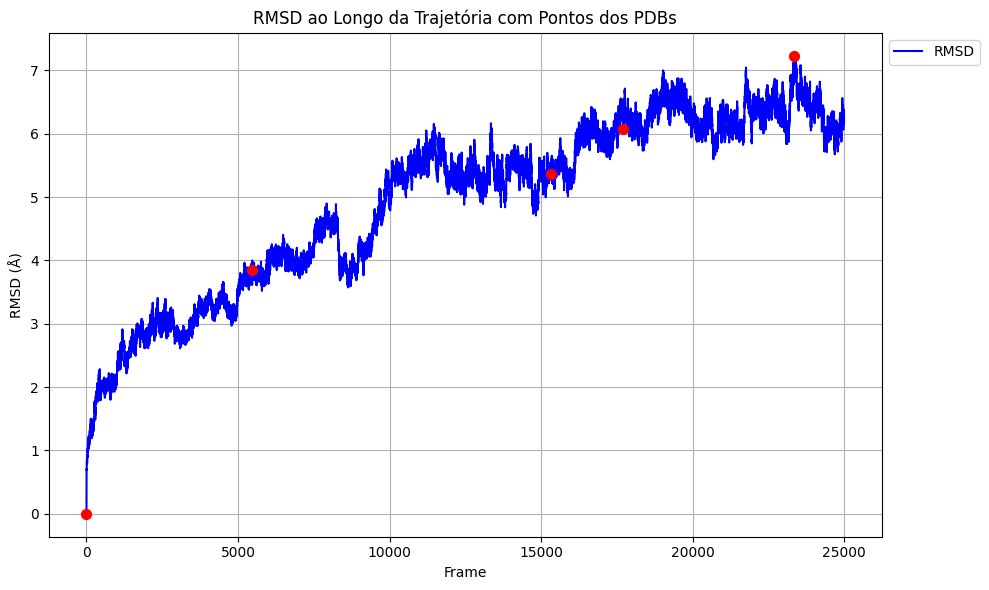

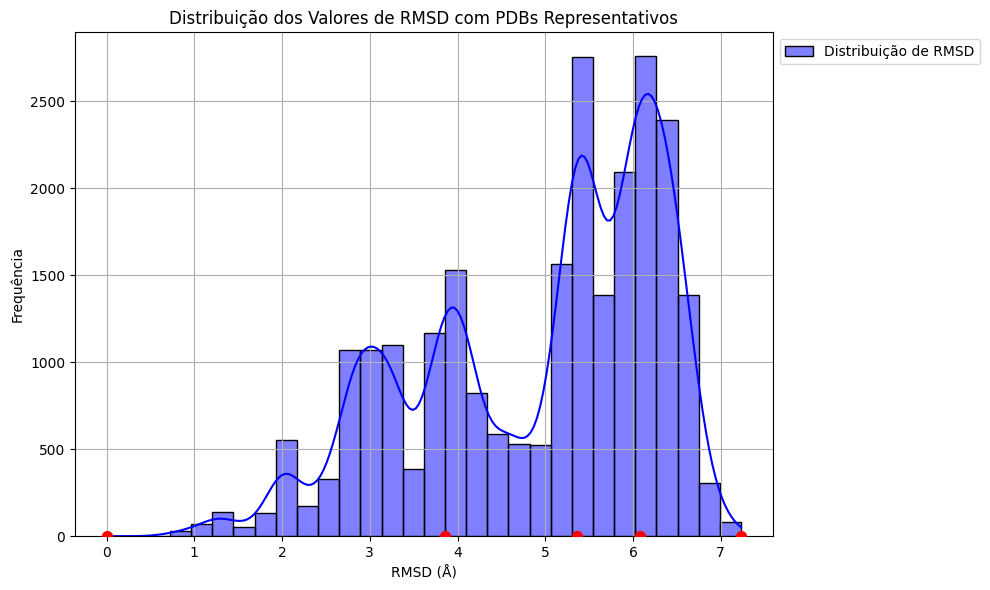

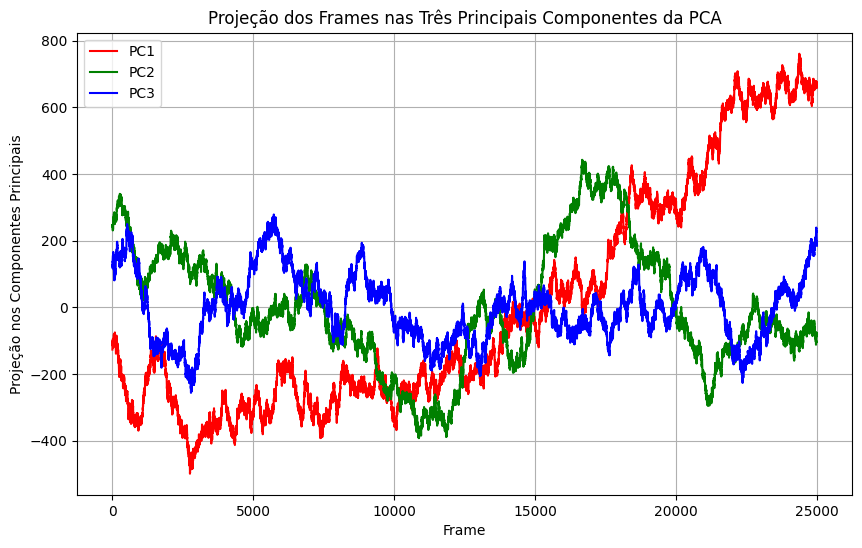

Arquivos PDB dos frames selecionados foram salvos com as descrições ajustadas.


In [2]:
if __name__ == "__main__":

    md_traj = MDTraj("/media/leon/FEDF-FDB3/md_thil_10replicates_100ns/1_replica/water_remov/1/5cc8_wr_1.prmtop",
                "/media/leon/FEDF-FDB3/md_thil_10replicates_100ns/1_replica/water_remov/1/5cc8_wr_1.dcd")
    
    md_traj.main()
    # md_traj.save_pdb()